# Produce training data via SAME-ECOS simulation 

In [1]:
import SAME_ECOS_functions as se
from SAME_ECOS_functions import *
import time
import datetime
import numpy as np
import scipy.io as sio
import math
import itertools

In [2]:
### An example to display the usage of a SAME-ECOS function
se.T2_components_resolution_finite_domain(SNR=200, T2_min=3, T2_max=150)

3.5199999999999685

In [3]:
TE = np.arange(2,50,2)
TE

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])

In [4]:
se.T2_boundary(SNR=100, echo_3=6, echo_last=48)

(2.0, 10.0)

In [5]:
T2_location = np.asarray([10,64,48])
T2_amplitude = np.asarray([0.2,0.5,0.3])

## T2 peak generation

In [6]:
def t2star_location(my_mu=10, my_sigma=1, ax_mu=72, ax_sigma=10, ex_mu=48, ex_sigma=6):
    
    t2_my = np.random.normal(my_mu, my_sigma)
    t2_ax = np.random.normal(ax_mu, ax_sigma)
    t2_ex = np.random.normal(ex_mu, ex_sigma)
    
    return np.asarray([t2_my, t2_ax, t2_ex])

In [7]:
t2star_location()

array([11.41638554, 71.19220734, 39.80254513])

In [8]:
def t2star_amplitude(mwf_upper_bound=0.5):
    mwf = np.random.uniform(0, mwf_upper_bound)
    axwf = np.random.uniform(0, 1) * (1 - mwf)
    exwf = 1 - mwf - axwf
    
    return np.asarray([mwf, axwf, exwf])

In [9]:
t2star_amplitude()

array([0.10707489, 0.28412729, 0.60879782])

In [10]:
def mgre_signal(T2_location, T2_amplitude, TE, model=2):
    signal = np.zeros(TE.shape[0])
    alpha = (22/180)*math.pi
    TR = 100
    T1 = T2_location*20
    T1_correction = np.sin(alpha)*(1-np.exp(-TR/T1))/(1-np.cos(alpha)*np.exp(-TR/T1))
    
    for t2_amp, t2_loc, t1_corr in zip(T2_amplitude, T2_location, T1_correction):
        if model == 1:
            signal += t2_amp * np.exp(-TE/t2_loc)
        if model == 2:
            signal += t2_amp * np.exp(-TE/t2_loc) * t1_corr
            
    return signal

In [11]:
signal = mgre_signal(t2star_location(), t2star_amplitude(), TE, model=2)
signal

array([0.22637028, 0.20372134, 0.18443915, 0.1679641 , 0.15383179,
       0.14165679, 0.13111909, 0.12195294, 0.11393762, 0.10688968,
       0.10065662, 0.09511163, 0.09014914, 0.08568126, 0.08163474,
       0.0779485 , 0.07457153, 0.07146121, 0.06858185, 0.06590356,
       0.06340124, 0.06105376, 0.05884335, 0.05675494])

In [12]:
signal_noisy = se.signal_with_noise_generation_phase_rotation(signal, SNR=100)
signal_noisy

array([0.24488227, 0.20273323, 0.1814989 , 0.18656701, 0.15954617,
       0.12824008, 0.1316471 , 0.13044851, 0.11833085, 0.11018979,
       0.10411352, 0.09979526, 0.09500396, 0.08403489, 0.08742677,
       0.07522689, 0.06302133, 0.05776934, 0.08326847, 0.07858848,
       0.06835496, 0.06052261, 0.07601854, 0.0574956 ])

In [13]:
def produce_mgre_data(realizations=10000,
                      SNR_boundary_low=50,
                      SNR_boundary_high=300,
                      echo_1st=2,
                      echo_last=48,
                      echo_spacing=2,
                      num_t2_basis=20,
                      peak_width=1,
                      T2_min_universal=3,
                      T2_max_universal=300,
                      exclude_M_max=False):
    """
    Produce training data via SAME-ECOS simulation pipeline (use a single cpu core).

    Args:
        decay_lib (array): the decay library
        realizations (int, optional): the number of simulation realizations. Defaults to 10000.
        SNR_boundary_low (float, optional): lower boundary of SNR. Defaults to 50.
        SNR_boundary_high (float, optional): upper boundary of SNR. Defaults to 800.
        echo_3 (float, optional): the 3rd echo time in ms. Defaults to 30.
        echo_last (float, optional): the last echo time in ms. Defaults to 320.
        echo_train_num (int, optional): the number of echoes in the echo train. Defaults to 32.
        num_t2_basis (int, optional): the number of basis t2s. Defaults to 40.
        FA_min (float, optional): the minimal refocusing flip angle (degree) for simulation. Defaults to 50.
        peak_width (float, optional): the variance of the gaussian peak. Defaults to 1.
        T2_min_universal (float, optional): the overall minimal T2 (ms) of the analysis. Defaults to calculate on the fly if None is given.
        T2_max_universal (float, optional): the overall maximal T2 (ms) of the analysis. Defaults to to 2000ms if None is given.
        exclude_M_max (bool, optional): exclude the M_max if True. Defaults to True.

    Returns:
        data: dictionary collection of the produced training data
    """

    # Define T2 range, maximum number (M_max) of T2 peaks at the highest SNR, allowable number (N) of T2 peaks for simulation
    TE = np.arange(echo_1st, echo_last+echo_spacing, echo_spacing)
    echo_train_num = TE.shape[0]
    if T2_min_universal == None:
        # Lower boundary is determined by the highest SNR
        T2_min_universal, _ = T2_boundary(SNR_boundary_high, echo_3, echo_last)
    if T2_max_universal == None:
        T2_max_universal = 2000  # empirically determined
    t2_basis = t2_basis_generator(
        T2_min_universal, T2_max_universal, num_t2_basis)
    M_max = int(np.floor(T2_components_resolution_finite_domain(
        SNR_boundary_high, T2_min_universal, T2_max_universal)))  # M at highest SNR
    # resolution_max = resloution_limit(T2_min_universal, T2_max_universal, M_max) ## resolution at highest SNR
    if exclude_M_max == True:
        N = M_max - 1  # for simulation M_max is excluded
    else:
        N = M_max
    # Create placeholders for memory efficiency
    T2_location_all = np.zeros([realizations, N])
    T2_amplitude_all = np.zeros([realizations, N])
    decay_curve_all = np.zeros([realizations, echo_train_num])
    decay_curve_with_noise_all = np.zeros([realizations, echo_train_num])
    train_label_all = np.zeros([realizations, num_t2_basis])
    train_label_gaussian_all = np.zeros([realizations, num_t2_basis])
    num_T2_SNR_FA_all = np.zeros([realizations, 2])
    # For each realization
    for i in range(realizations):
        # Randomly determine the SNR, the minimum T2, the number of T2s (must < M), and the flip angle FA.
        # SNR = 100 ## for fixed SNR
        SNR = np.random.randint(SNR_boundary_low, SNR_boundary_high)
        T2_min, _ = T2_boundary(SNR, TE[2], TE[-1])
        if T2_min < T2_min_universal:
            T2_min = T2_min_universal
        T2_max = T2_max_universal
        M = np.floor(T2_components_resolution_finite_domain(
            SNR, T2_min, T2_max))
        if exclude_M_max == True:
            N_choice = np.arange(1, M)
        else:
            N_choice = np.arange(1, M+1)
        weight = N_choice**0.5  # weighting factor for each choice
        num_T2 = int(np.random.choice(N_choice, p=weight/weight.sum()))
        # Calculate the resolution limit
        resolution = resloution_limit(T2_min, T2_max, M)
        # Randomly generate T2 peak location with respect to resolution limit.
        #T2_location = T2_location_generator_v3(T2_min, T2_max, num_T2, num_t2_basis, resolution, log_cutoff=10, smooth=False)
        T2_location = T2_location_generator_v3(
            T2_min, T2_max, num_T2, M_max, scale='log')
        while T2_resolution_examiner(T2_location, resolution) == False:
            T2_location = T2_location_generator_v3(
                T2_min, T2_max, num_T2, M_max, scale='log')
        # Randomly generate T2 peak amplitude. When two or more peaks, minimal detectable amplitude is calculated
        if num_T2 == 1:
            T2_amplitude = np.array([1.0])
        else:
            _, frequency = required_frequency(T2_location)
            minimum_amplitude = minimum_amplitude_calculator(SNR, frequency)
            T2_amplitude = T2_amplitude_generator_v3(num_T2, minimum_amplitude)
        # Decay curve generation (weighted sum of each T2 component)
        decay_curve = mgre_signal(T2_location, T2_amplitude, TE, model=2)
        # Add noise to decay curve
        decay_curve_with_noise = signal_with_noise_generation_phase_rotation(
            signal=decay_curve, SNR=SNR)
        # T2 basis set embedding (nearest t2_basis neighbors)
        train_label = train_label_generator(
            T2_location, T2_amplitude, t2_basis)
        # T2 basis set embedding (gaussian peaks)
        train_label_gaussian = train_label_generator_gaussian_embedding(
            T2_location, T2_amplitude, T2_min_universal, T2_max_universal, t2_basis, peak_width)
        # Extract metrics (use t2_basis and train label instead of T2_location and T2_amplitude to prevent basis set embedding error)
        #MWF, MWGMT2, IEWF, IEWGMT2, GMT2 = metrics_extraction_v3(t2_basis, train_label, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)
        # Ground truth metrics (use tT2_location and T2_amplitude)
        #MWF_GT, MWGMT2_GT, IEWF_GT, IEWGMT2_GT, GMT2_GT = metrics_extraction_v3(T2_location, T2_amplitude, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)
        # Pad T2_location and T2_amplitude to have uniform size
        T2_location = np.pad(
            T2_location, [(0, N-int(num_T2))], mode='constant', constant_values=0)
        T2_amplitude = np.pad(
            T2_amplitude, [(0, N-int(num_T2))], mode='constant', constant_values=0)
        # Store generated parameters in placeholders
        T2_location_all[i, :] = T2_location
        T2_amplitude_all[i, :] = T2_amplitude
        decay_curve_all[i, :] = decay_curve
        decay_curve_with_noise_all[i, :] = decay_curve_with_noise
        train_label_all[i, :] = train_label
        train_label_gaussian_all[i, :] = train_label_gaussian
        num_T2_SNR_FA_all[i, :] = num_T2, SNR
    # return a data dict
    data = {'T2_location': T2_location_all,
            'T2_amplitude': T2_amplitude_all,
            'decay_curve': decay_curve_all,
            'decay_curve_with_noise': decay_curve_with_noise_all,
            'train_label': train_label_all,
            'train_label_gaussian': train_label_gaussian_all,
            'num_T2_SNR': num_T2_SNR_FA_all,
            }
    return data

In [14]:
data = produce_mgre_data(realizations=1000,
                         SNR_boundary_low=50,
                         SNR_boundary_high=300,
                         echo_1st=2,
                         echo_last=46,
                         echo_spacing=4,
                         num_t2_basis=40,
                         peak_width=1,
                         T2_min_universal=3,
                         T2_max_universal=2000,
                         exclude_M_max=True)

In [15]:
def mp_yield_mgre_data(func_produce_training_data,
                       realizations,
                       ncores,
                       SNR_boundary_low=100,
                       SNR_boundary_high=500,
                       echo_1st=2,
                       echo_last=48,
                       echo_spacing=2,
                       num_t2_basis=40,
                       peak_width=1,
                       T2_min_universal=3,
                       T2_max_universal=2000,
                       exclude_M_max=False):
    """
    Use multiple cpu cores to accelerate training data production using multiprocessing package.

    Args:
        func_produce_training_data (function): the function to produce training data using a single cpu core.
        decay_lib (array): the decay library.
        realizations (int): the number of simulation realizations.
        ncores (int): number of cpu cores to use.
        SNR_boundary_low (float, optional): lower boundary of SNR. Defaults to 50.
        SNR_boundary_high (float, optional): upper boundary of SNR. Defaults to 800.
        echo_3 (float, optional): the 3rd echo time (ms). Defaults to 30.
        echo_last (float, optional): the last echo time (ms). Defaults to 320.
        echo_train_num (int, optional): the number of echoes in the echo train. Defaults to 32.
        num_t2_basis (int, optional): the number of basis t2s. Defaults to 40.
        FA_min (float, optional): the minimal refocusing flip angle for simulation. Defaults to 50.
        peak_width (float, optional): the variance of the gaussian peak. Defaults to 1.
        T2_min_universal (float, optional): the overall minimal T2 (ms) of the analysis. Defaults to calculate on the fly if None is given.
        T2_max_universal (float, optional): the overall maximal T2 (ms) of the analysis. Defaults to to 2000ms if None is given.
        exclude_M_max (bool, optional): exclude the M_max if True. Defaults to True.

    Returns:
        data_all: a data dictionary concatenated from all cpu cores
    """

    import multiprocessing as mp
    pool = mp.Pool(processes=ncores)
    # distribute job to each cpu core
    realizations_pool_list = [realizations//ncores]*ncores
    if realizations % ncores != 0:
        realizations_pool_list.append(realizations % ncores)
    data = pool.starmap(func_produce_training_data, [(realizations,
                                                      SNR_boundary_low, SNR_boundary_high,
                                                      echo_1st, echo_last, echo_spacing,
                                                      num_t2_basis, peak_width,
                                                      T2_min_universal, T2_max_universal,
                                                      exclude_M_max)
                                                     for realizations in realizations_pool_list])
    pool.close()
    pool.join()
    # concatenate data calculated from each cpu core
    keys = data[0].keys()
    data_all = {key: None for key in keys}
    for key in keys:
        data_all[key] = np.concatenate(
            [data[x][key] for x in range(len(data))])
    return data_all

In [16]:
data = mp_yield_mgre_data(produce_mgre_data,
                          realizations=1000000,
                          ncores=8,
                          SNR_boundary_low=100,
                          SNR_boundary_high=500,
                          echo_1st=2,
                          echo_last=48,
                          echo_spacing=2,
                          num_t2_basis=20,
                          peak_width=1,
                          T2_min_universal=5,
                          T2_max_universal=1500,
                          exclude_M_max=True)

In [17]:
data['num_T2_SNR']

array([[  1., 164.],
       [  3., 463.],
       [  1., 125.],
       ...,
       [  3., 488.],
       [  2., 217.],
       [  3., 274.]])

In [18]:
data.keys()

dict_keys(['T2_location', 'T2_amplitude', 'decay_curve', 'decay_curve_with_noise', 'train_label', 'train_label_gaussian', 'num_T2_SNR'])

produced training data contains
- T2_location: T2 peak locations of each realization
- T2_amplitude: T2 peak amplitudes of each realization
- decay_curve: the pure signal at each echo of each realization
- decay_curve_with_noise: the signal at each echo of each realization with noise added
- train_label: the T2 spectrum (each T2 peak is depicted by two nearest basis t2s)
- train_label_gaussian: the T2 spectrum (each T2 peak is depicted by gaussian shaped basis t2s)
- num_T2_SNR_FA: a collection array of number of T2 peaks, selected SNR, and selected flip angle of each realization

# SAME-ECOS model training

In [19]:
import sklearn
import tensorflow as tf
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
### store training input data in variable x
x = data['decay_curve_with_noise']
### normalization the input data to its first echo
x=x/x[:,0].reshape(x.shape[0],1) 
x.shape

(1000000, 24)

In [21]:
### store training label in variable y
y = data['train_label_gaussian']
y.shape

(1000000, 20)

In [22]:
### split the dataset into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=10)

In [23]:
print('training x: '+ str(x_train.shape))
print('training y: '+ str(y_train.shape))
print('validation x: '+ str(x_val.shape))
print('validation y: '+ str(y_val.shape))
print('testing x: '+ str(x_test.shape))
print('testing y: '+ str(y_test.shape))

training x: (810000, 24)
training y: (810000, 20)
validation x: (90000, 24)
validation y: (90000, 20)
testing x: (100000, 24)
testing y: (100000, 20)


In [24]:
### Setting up neural network hyperparameters
hidden_layers=[500, 500, 1000, 1000, 500, 500] # a list of nodes in each hidden layer and can be changed as you wish
output_layer_nodes = y.shape[1]
Batch_norm = 'yes' # use batch normalization
acti='selu' # activation function
initial='lecun_normal' # weight initialization
selected_metrics=[tf.keras.metrics.CosineSimilarity(axis=-1)]
selected_optimizer = keras.optimizers.Adamax(lr=0.005)
# loss_function = 'cosine_similarity'
loss_function = 'categorical_crossentropy' # other loss functions can be used as well.
# loss_function = 'mean_squared_error'
l1_strength = 0 # L1 regularization parameter
l2_strength = 0 # L2 regularization parameter
num_epoch = 25

In [25]:
### Train and test the neural network model, and store training and testing history in 'NN_training.txt'
f = open("NN_training.txt", "a")
now = datetime.datetime.now()
f.write("Date and Time: {} \n".format(now.strftime("%Y-%m-%d %H:%M:%S")))
f.write('selected hidden layer structure = {} \n'.format(hidden_layers))
f.write('activation = {}, initialization = {} \n'.format(acti, initial))
f.write('Batch_norm = {}, loss_function = {}, regularization_strength = {},\nselected_optimizer = {} \n \n \n'.format(
    Batch_norm, loss_function, l2_strength, selected_optimizer))

keras.backend.clear_session()
model = keras.Sequential()
if Batch_norm == 'yes':
    model.add(keras.layers.BatchNormalization())
for nodes in hidden_layers:
    model.add(keras.layers.Dense(
        nodes, kernel_initializer=initial, activation=acti))
    if Batch_norm == 'yes':
        model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(output_layer_nodes, kernel_initializer=initial, activation='softmax',
          activity_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))

model.compile(optimizer=selected_optimizer, loss=loss_function, metrics=selected_metrics)

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_cosine_similarity', patience=15),
                  keras.callbacks.ModelCheckpoint(filepath='NN_model_example.h5',monitor='val_cosine_similarity',save_best_only=True),
                  keras.callbacks.ReduceLROnPlateau(monitor='cosine_similarity', factor=0.5, patience=2)]

start_time = time.time()
history = model.fit(x_train, y_train, epochs=40, batch_size=256,
                    callbacks=callbacks_list, validation_data=(x_val, y_val))

print("--- %.2f seconds ---" % (time.time() - start_time))
f.write("--- Training time %.2f seconds --- \n" % (time.time() - start_time))
print('training stopped at epoch = {}'.format(len(history.history['lr'])))
f.write('training stopped at epoch = {} \n \n'.format(
    len(history.history['lr'])))
f.write('validation similarity = {} \n \n'.format(list(round(i, 4)
        for i in history.history['val_cosine_similarity'])))
f.write('learning rate = {} \n \n'.format(list(round(i, 6)
        for i in history.history['lr'])))

### apply trained model to the test set
NN_predict = model.predict(x_test)

### evaluate the model performance using cosine similarity scores
similarity_score = np.zeros((y_test.shape[0], 1))
for item in range(y_test.shape[0]):
    similarity_score[item, :] = cosine_similarity(
        NN_predict[item, :].reshape(1, -1), y_test[item, :].reshape(1, -1))
print('Average similarity for each spectrum in the test set = {} +/- {} \n'.format(
    similarity_score.mean(), similarity_score.std()))
f.write('Average similarity for each spectrum in the test set = {} +/- {} \n'.format(
    similarity_score.mean(), similarity_score.std()))
f.write('#############################################\n')
f.write('\n \n')
f.close()

Epoch 1/40
3165/3165 [==============================] - 39s 12ms/step - loss: 2.4125 - cosine_similarity: 0.7810 - val_loss: 2.3703 - val_cosine_similarity: 0.7936
Epoch 2/40
3165/3165 [==============================] - 38s 12ms/step - loss: 2.3444 - cosine_similarity: 0.8054 - val_loss: 2.3772 - val_cosine_similarity: 0.8031
Epoch 3/40
3165/3165 [==============================] - 38s 12ms/step - loss: 2.3342 - cosine_similarity: 0.8108 - val_loss: 2.3737 - val_cosine_similarity: 0.8126
Epoch 4/40
3165/3165 [==============================] - 38s 12ms/step - loss: 2.3233 - cosine_similarity: 0.8161 - val_loss: 2.3285 - val_cosine_similarity: 0.8200
Epoch 5/40
3165/3165 [==============================] - 38s 12ms/step - loss: 2.3216 - cosine_similarity: 0.8170 - val_loss: 2.3814 - val_cosine_similarity: 0.8170
Epoch 6/40
3165/3165 [==============================] - 38s 12ms/step - loss: 2.3173 - cosine_similarity: 0.8195 - val_loss: 2.4073 - val_cosine_similarity: 0.8230
Epoch 7/40
3165/

# Evaluate the trained model performance 

In [26]:
import matplotlib.pyplot as plt

In [27]:
### use 40 basis t2s to depict the spectrum  
t2_basis = se.t2_basis_generator(5, 1500, 20)

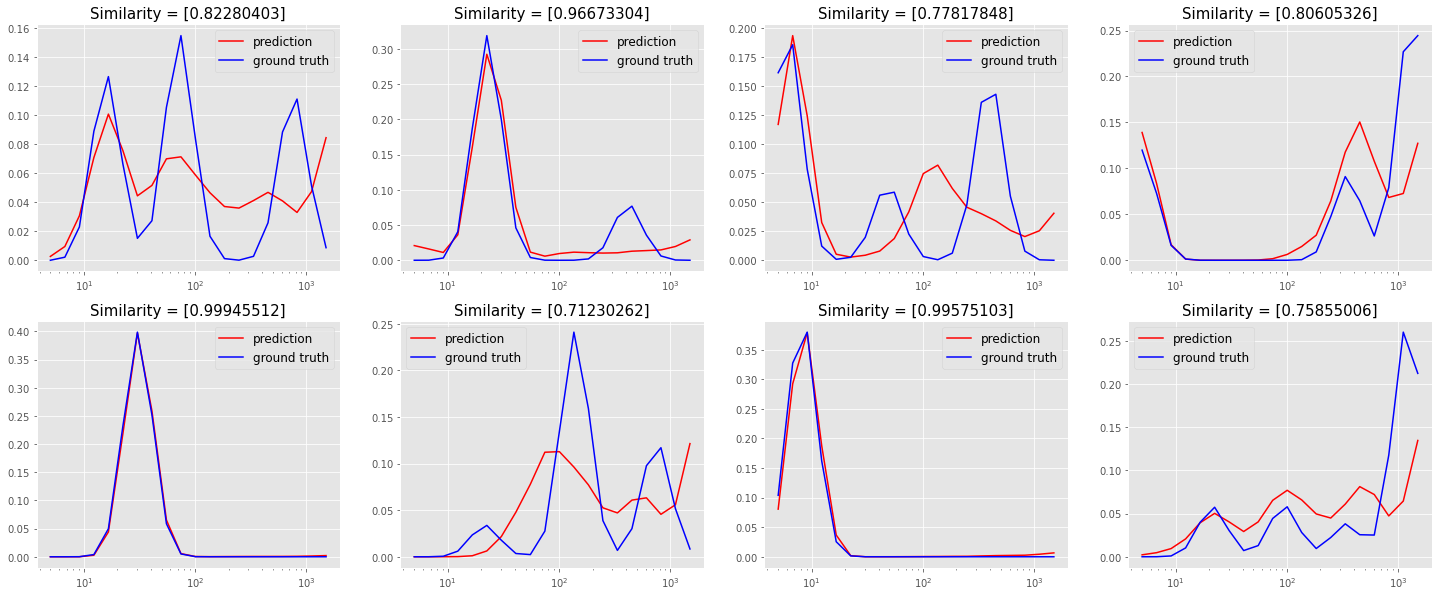

In [28]:
### randomly pick a few test examples and plot them
nrow = 2
ncol = 4
plt.figure(figsize=(25,10))
plt.style.use('ggplot')
for i in range(nrow*ncol):
    plt.subplot(nrow, ncol, i+1)
    random_pick = np.random.randint(0, y_test.shape[0])
    plt.plot(t2_basis, NN_predict[random_pick,:], 'r', label='prediction')
    plt.plot(t2_basis, y_test[random_pick,:], 'b', label='ground truth')
    plt.legend(fontsize=12)
    plt.xscale('log')
    plt.title('Similarity = {}'.format(similarity_score[random_pick]), fontsize=15)
plt.show()

In [196]:
### uncomment the line below if you want to save the trained model
# model.save('NN_model.h5')

# Apply trained model to experimental data

- The experimental data is not provided in the on github repo. Pictures shown in this section only serves demonstration purpose.
- Please use your own MWI data.
- You should get similar results as shown in this section

In [29]:
import nibabel as nib
from dipy.denoise.gibbs import gibbs_removal
from dipy.denoise.localpca import mppca

In [30]:
file_path = 'mGRE_T2star.nii' # replace with the path to your MWI image data in nii or nii.gz or mnc format
img = nib.load(file_path)
img_data = img.get_fdata()

In [31]:
#img_data = gibbs_removal(img_data, slice_axis=0, inplace=False)

In [32]:
#img_datag = mppca(img_data)

In [33]:
# The last dimension should be the time axis (echoes)
img_data = np.swapaxes(img_data,0,2)
img_data.shape

(120, 106, 135, 24)

In [34]:
#img_data = img_data[:,:,:,0:25:2]

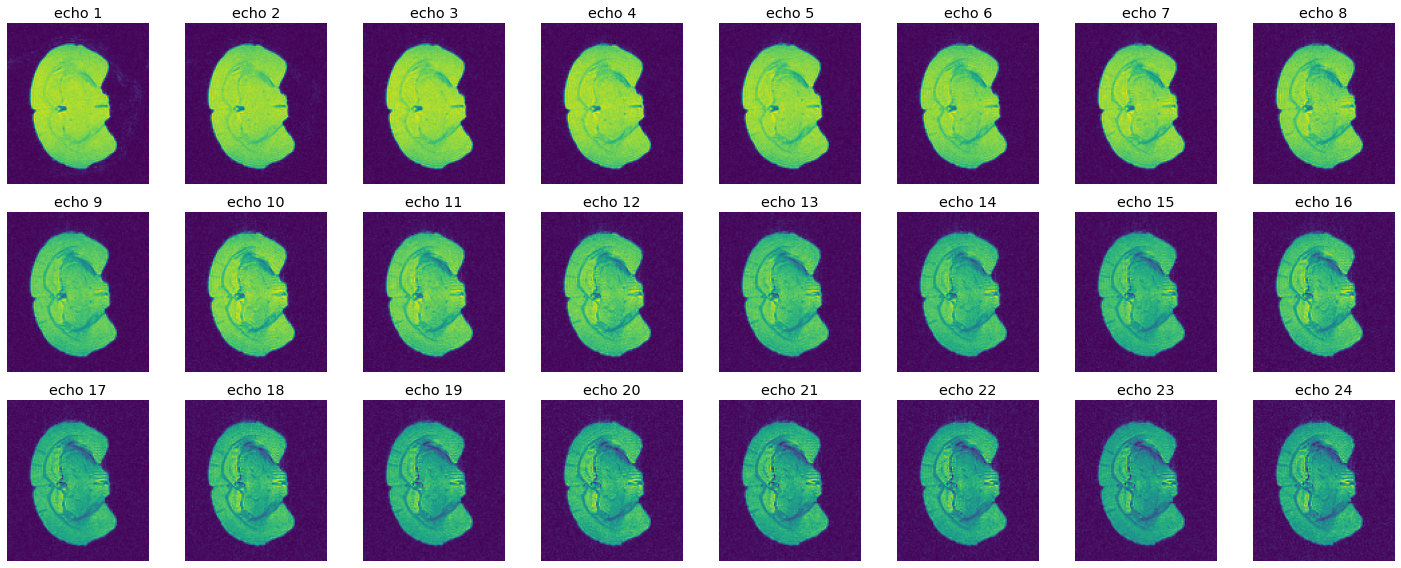

In [35]:
# The following function plots the 32 echoes for the 8th slice.
se.plot_all_echoes(img_data, slice_num=70, rows=3, columns=8, fig_size=(20,8), tight=True)

In [36]:
### Carry out the T2 spectrum using the neural network model trained above
NN_predict_spectrum = se.NN_predict_4D_decay(img_data, model)

In [37]:
### The last dimension of the 'se.quantitative_map_production' output the following 5 metrics (MWF, MWGMT2, IEWF, IEWGMT2, GMT2)
NN_predict_metrics = se.quantitative_map_production(t2_basis,
                                                    NN_predict_spectrum,
                                                    MW_low_cutoff=0,
                                                    MW_high_cutoff=25,
                                                    IEW_low_cutoff=25,
                                                    IEW_high_cutoff=150)

In [41]:
NN_predict_metrics = NN_predict_metrics[:,:,:,0]*mask

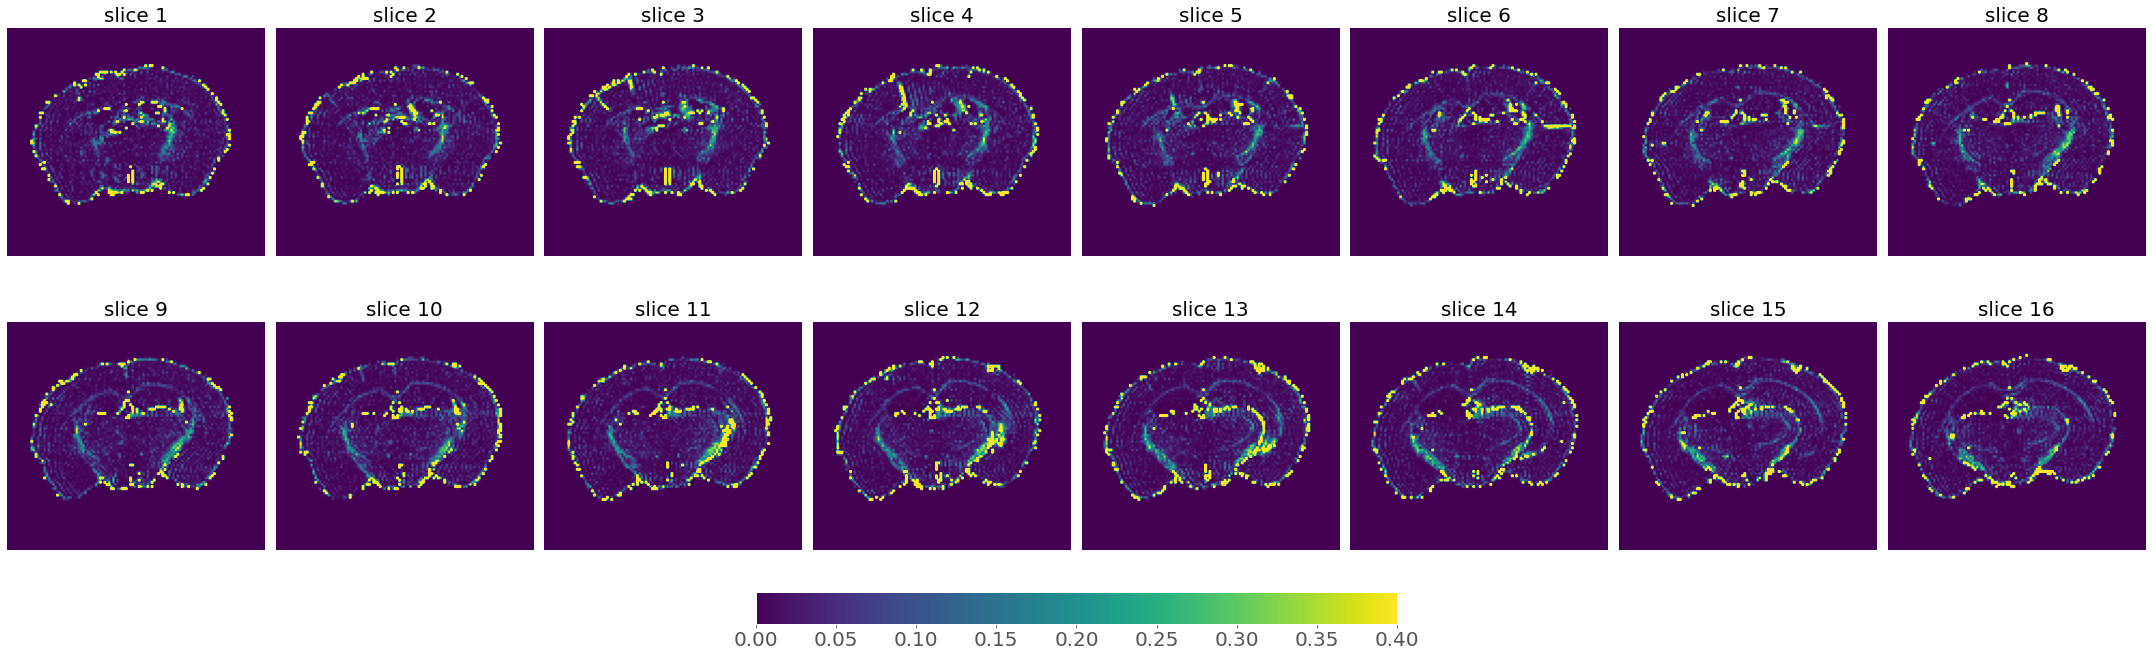

In [44]:
### plot the MWF map of all slices
### t2_basis = se.t2_basis_generator(5, 1500, 20)
se.plot_all_slice(np.rot90(NN_predict_metrics[:,:,60:76],3), nrow=2, ncol=8, vmin=0, vmax=0.4)

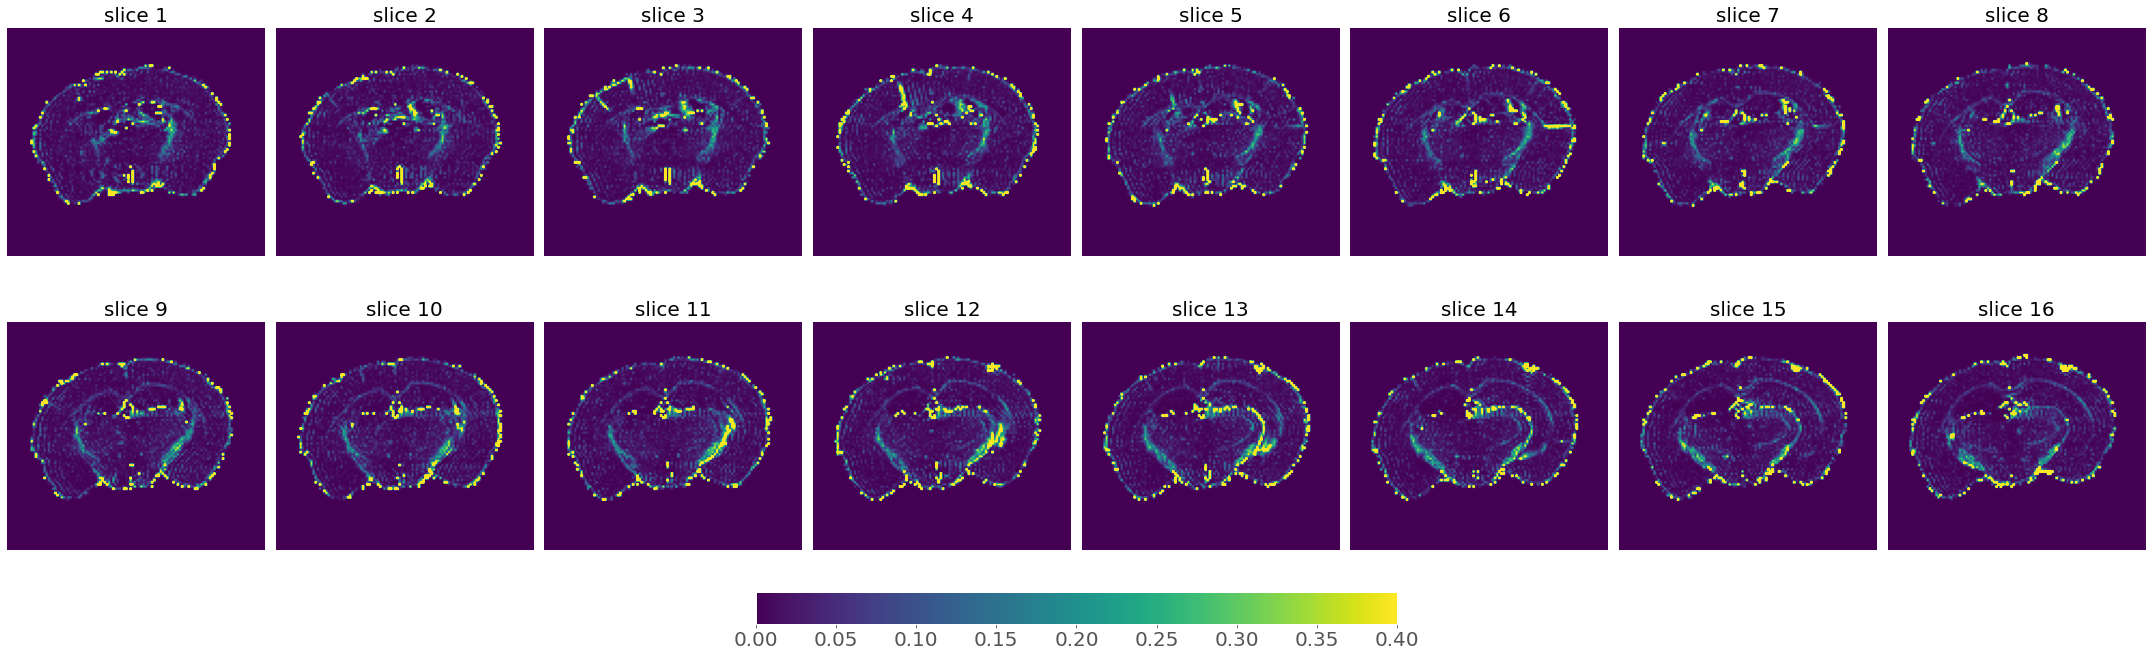

In [126]:
### plot the MWF map of all slices
### t2_basis = se.t2_basis_generator(3, 1500, 20)
se.plot_all_slice(np.rot90(NN_predict_metrics[:,:,60:76],3), nrow=2, ncol=8, vmin=0, vmax=0.4)

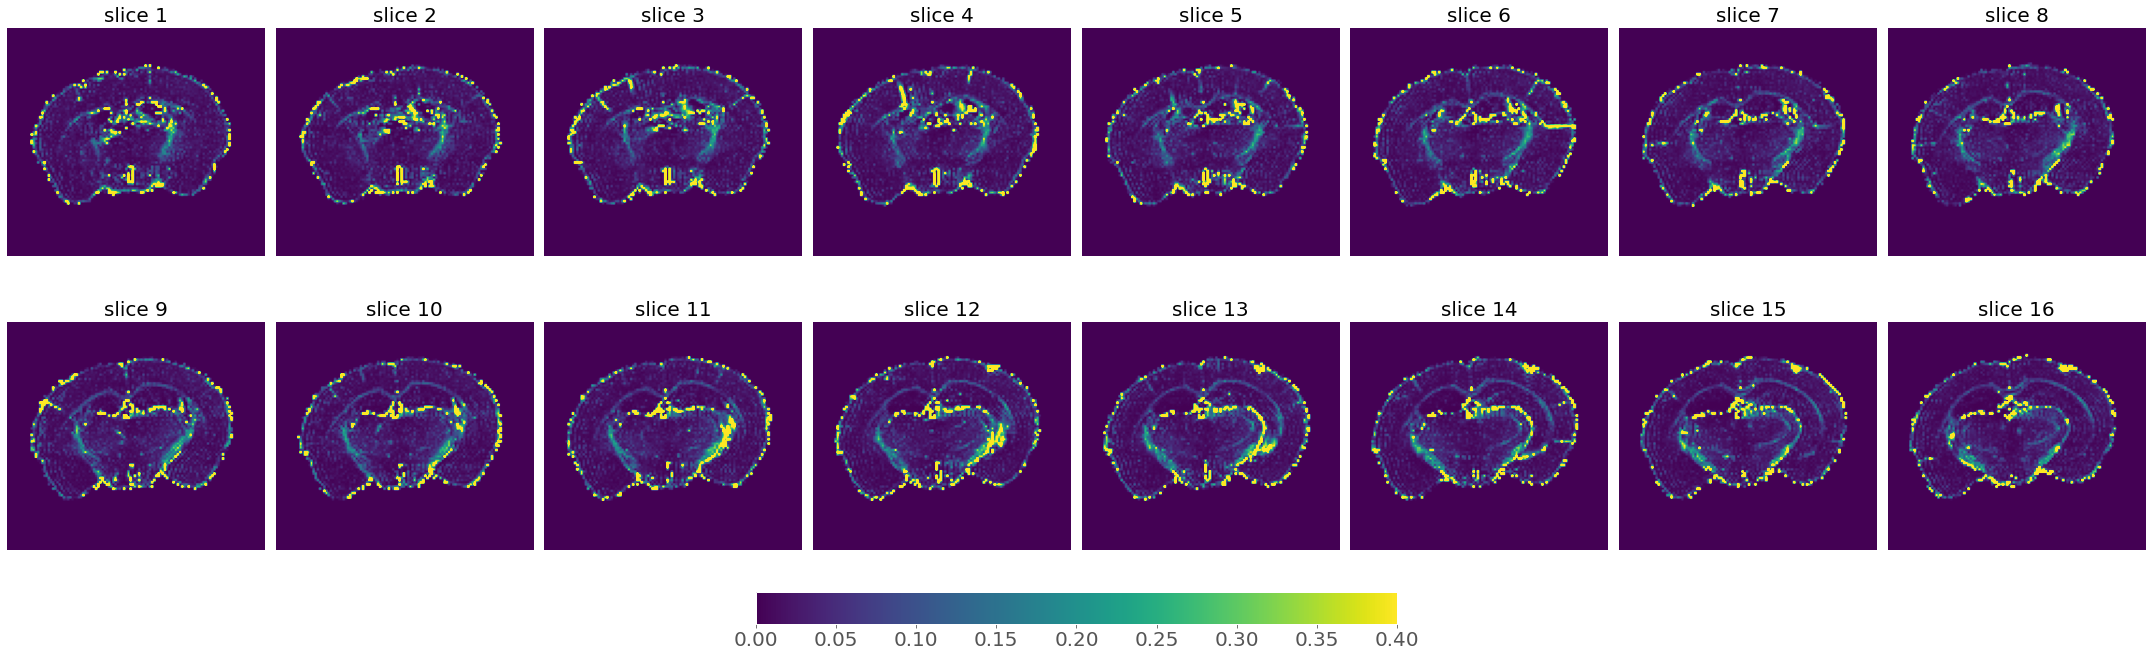

In [140]:
### plot the MWF map of all slices
### t2_basis = se.t2_basis_generator(1, 1500, 20)
se.plot_all_slice(np.rot90(NN_predict_metrics[:,:,60:76],3), nrow=2, ncol=8, vmin=0, vmax=0.4)

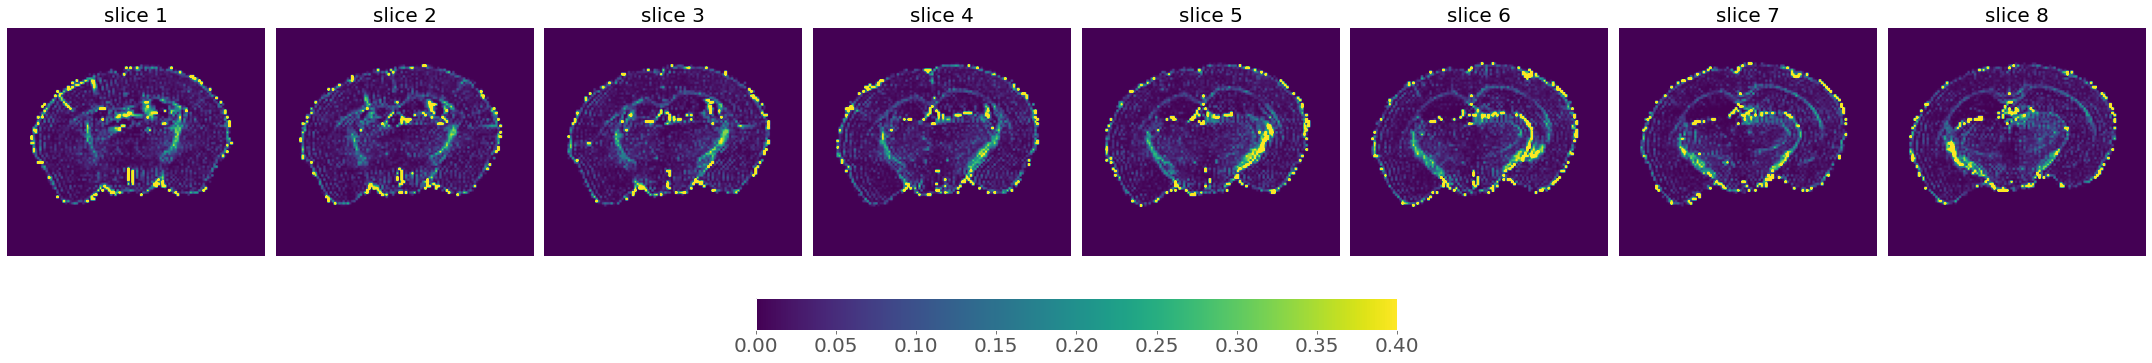

In [155]:
### plot the MWF map of all slices
### t2_basis = se.t2_basis_generator(5, 1500, 20)
se.plot_all_slice(np.rot90(NN_predict_metrics[:,:,62:78:2],3), nrow=1, ncol=8, vmin=0, vmax=0.4)

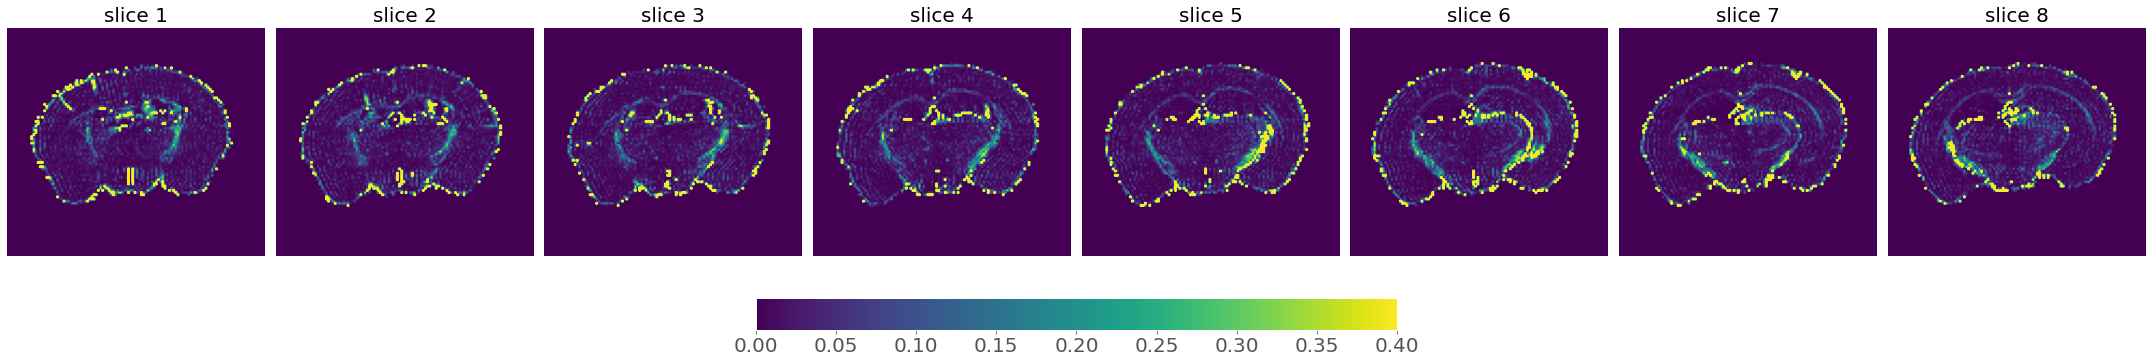

In [45]:
### plot the MWF map of all slices
### t2_basis = se.t2_basis_generator(5, 1500, 20)
se.plot_all_slice(np.rot90(NN_predict_metrics[:,:,62:78:2],3), nrow=1, ncol=8, vmin=0, vmax=0.4)

## NNLS analysis

In [157]:
import matlab
import matlab.engine

In [158]:
eng = matlab.engine.start_matlab()

In [159]:
eng.addpath('/export01/data/Hanwen/matlab_tools/MWI_NNLS_toolbox_0319/');

In [160]:
eng.workspace['data'] = matlab.double(img_data.tolist())

In [161]:
# number of cpu cores available for NNLS calculation
maxCores = 8

In [162]:
maps_NNLS, distributions_NNLS = eng.T2map_SEcorr_nechoes_2019(
    eng.workspace['data'],
    maxCores,
    'TE', matlab.double([0.002]),
    'nT2', matlab.double([20]),
    'Threshold', matlab.double([1]),
    'SetFlipAngle', matlab.double([180]),
    'T2Range', matlab.double([0.005, 1.5]), # T2 range = 5-2000 ms
    nargout=2)

In [163]:
distributions_NNLS = np.asarray(distributions_NNLS)

In [164]:
t2_basis

array([   5.        ,    6.7506378 ,    9.11422215,   12.30536253,
         16.6138091 ,   22.43076156,   30.28438939,   40.88778878,
         55.20373055,   74.53207808,  100.62781279,  135.86038345,
        183.42884815,  247.65234337,  334.36225433,  451.43169492,
        609.49037322,  822.88975105, 1111.00613256, 1500.        ])

In [184]:
NNLS_predict_metrics = se.quantitative_map_production(t2_basis,
                                                      distributions_NNLS,
                                                      MW_low_cutoff=0,
                                                      MW_high_cutoff=25,
                                                      IEW_low_cutoff=25,
                                                      IEW_high_cutoff=150)

/export01/data/Hanwen/SAME-ECOS/SAME-ECOS_code/SAME_ECOS_functions.py:261: RuntimeWarning: invalid value encountered in double_scalars
  MWF = T2_amplitude[MW_loc].sum()/T2_amplitude.sum()
/export01/data/Hanwen/SAME-ECOS/SAME-ECOS_code/SAME_ECOS_functions.py:262: RuntimeWarning: invalid value encountered in double_scalars
  IEWF = T2_amplitude[IEW_loc].sum()/T2_amplitude.sum()
/export01/data/Hanwen/SAME-ECOS/SAME-ECOS_code/SAME_ECOS_functions.py:267: RuntimeWarning: invalid value encountered in double_scalars
  MWGMT2 = np.exp(np.dot(T2_amplitude[MW_loc], np.log(T2_location[MW_loc])) / T2_amplitude[MW_loc].sum())
/export01/data/Hanwen/SAME-ECOS/SAME-ECOS_code/SAME_ECOS_functions.py:271: RuntimeWarning: invalid value encountered in double_scalars
  IEWGMT2 = np.exp(np.dot(T2_amplitude[IEW_loc], np.log(T2_location[IEW_loc])) / T2_amplitude[IEW_loc].sum())
/export01/data/Hanwen/SAME-ECOS/SAME-ECOS_code/SAME_ECOS_functions.py:273: RuntimeWarning: invalid value encountered in double_scalars

In [171]:
#NNLS_predict_metrics[np.isnan(NNLS_predict_metrics)] = 0

In [172]:
### plot the MWF map of all slices
### t2_basis = se.t2_basis_generator(5, 1500, 40)
se.plot_all_slice(np.rot90(NNLS_predict_metrics[:,:,60:76,0],3), nrow=2, ncol=8, vmin=0, vmax=0.4)

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [39]:
mask =  nib.load('mGRE_T2star_bet_mask.nii.gz')
mask = mask.get_fdata()
mask.shape

(135, 106, 120)

In [40]:
mask = np.swapaxes(mask,0,2)
mask.shape

(120, 106, 135)

In [169]:
NNLS_predict_metrics = NNLS_predict_metrics[:,:,:,0]*mask

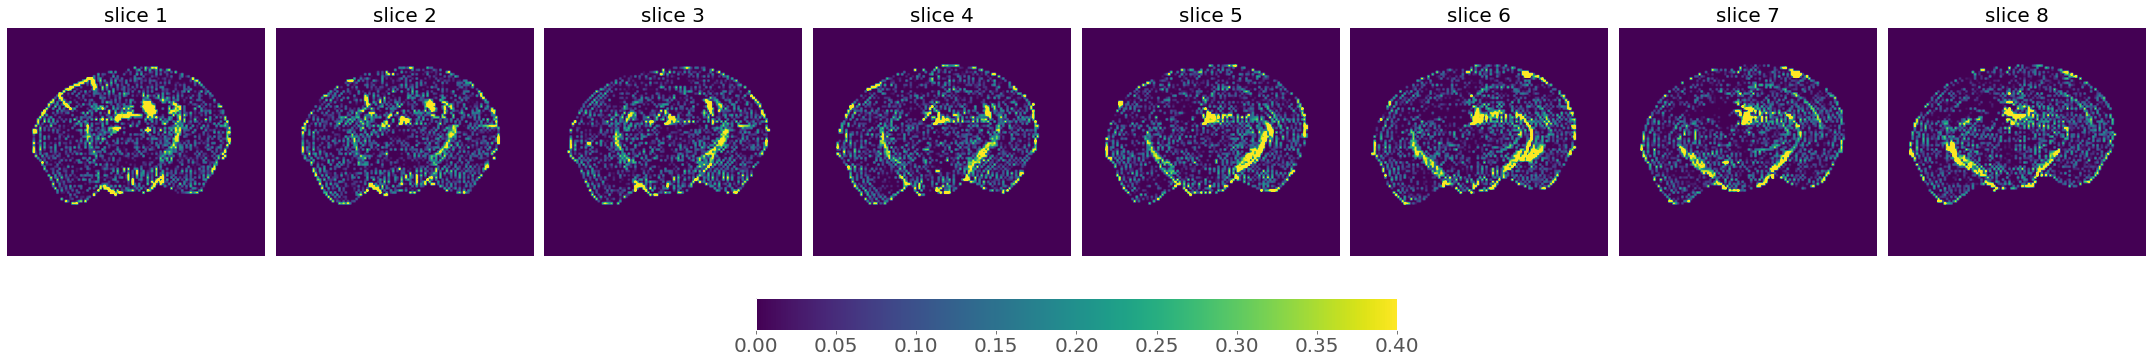

In [173]:
### plot the MWF map of all slices
### t2_basis = se.t2_basis_generator(5, 1500, 40)
se.plot_all_slice(np.rot90(NNLS_predict_metrics[:,:,62:78:2],3), nrow=1, ncol=8, vmin=0, vmax=0.4)

In [72]:
%store NNLS_predict_metrics

Stored 'NNLS_predict_metrics' (ndarray)


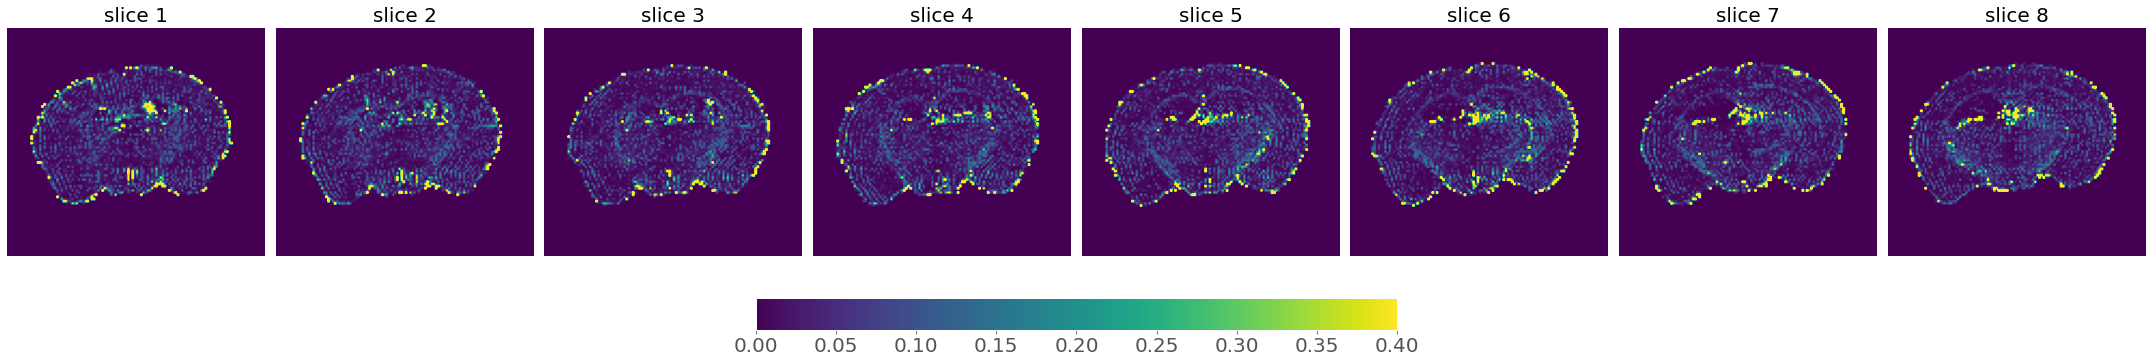

In [177]:
se.plot_all_slice(np.rot90(abs(NNLS_predict_metrics[:,:,62:78:2]-NN_predict_metrics[:,:,62:78:2]),3), nrow=1, ncol=8, vmin=0, vmax=0.4)

In [178]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [182]:
mean_absolute_error(NNLS_predict_metrics.flatten(), NN_predict_metrics.flatten())

0.01741102234961607

In [186]:
np.nanmean(NNLS_predict_metrics[:,:,:,0]-NN_predict_metrics)

0.03275381389711426

In [192]:
%store -r NN_predict

In [193]:
NN_predict.shape

(120, 106, 135)

In [191]:
NN_predict_metrics.shape

(120, 106, 135)

In [211]:
from scipy import stats

In [218]:
stats.pearsonr(NN_predict.flatten(), NN_predict_metrics.flatten())

(0.34827482356248335, 0.0)

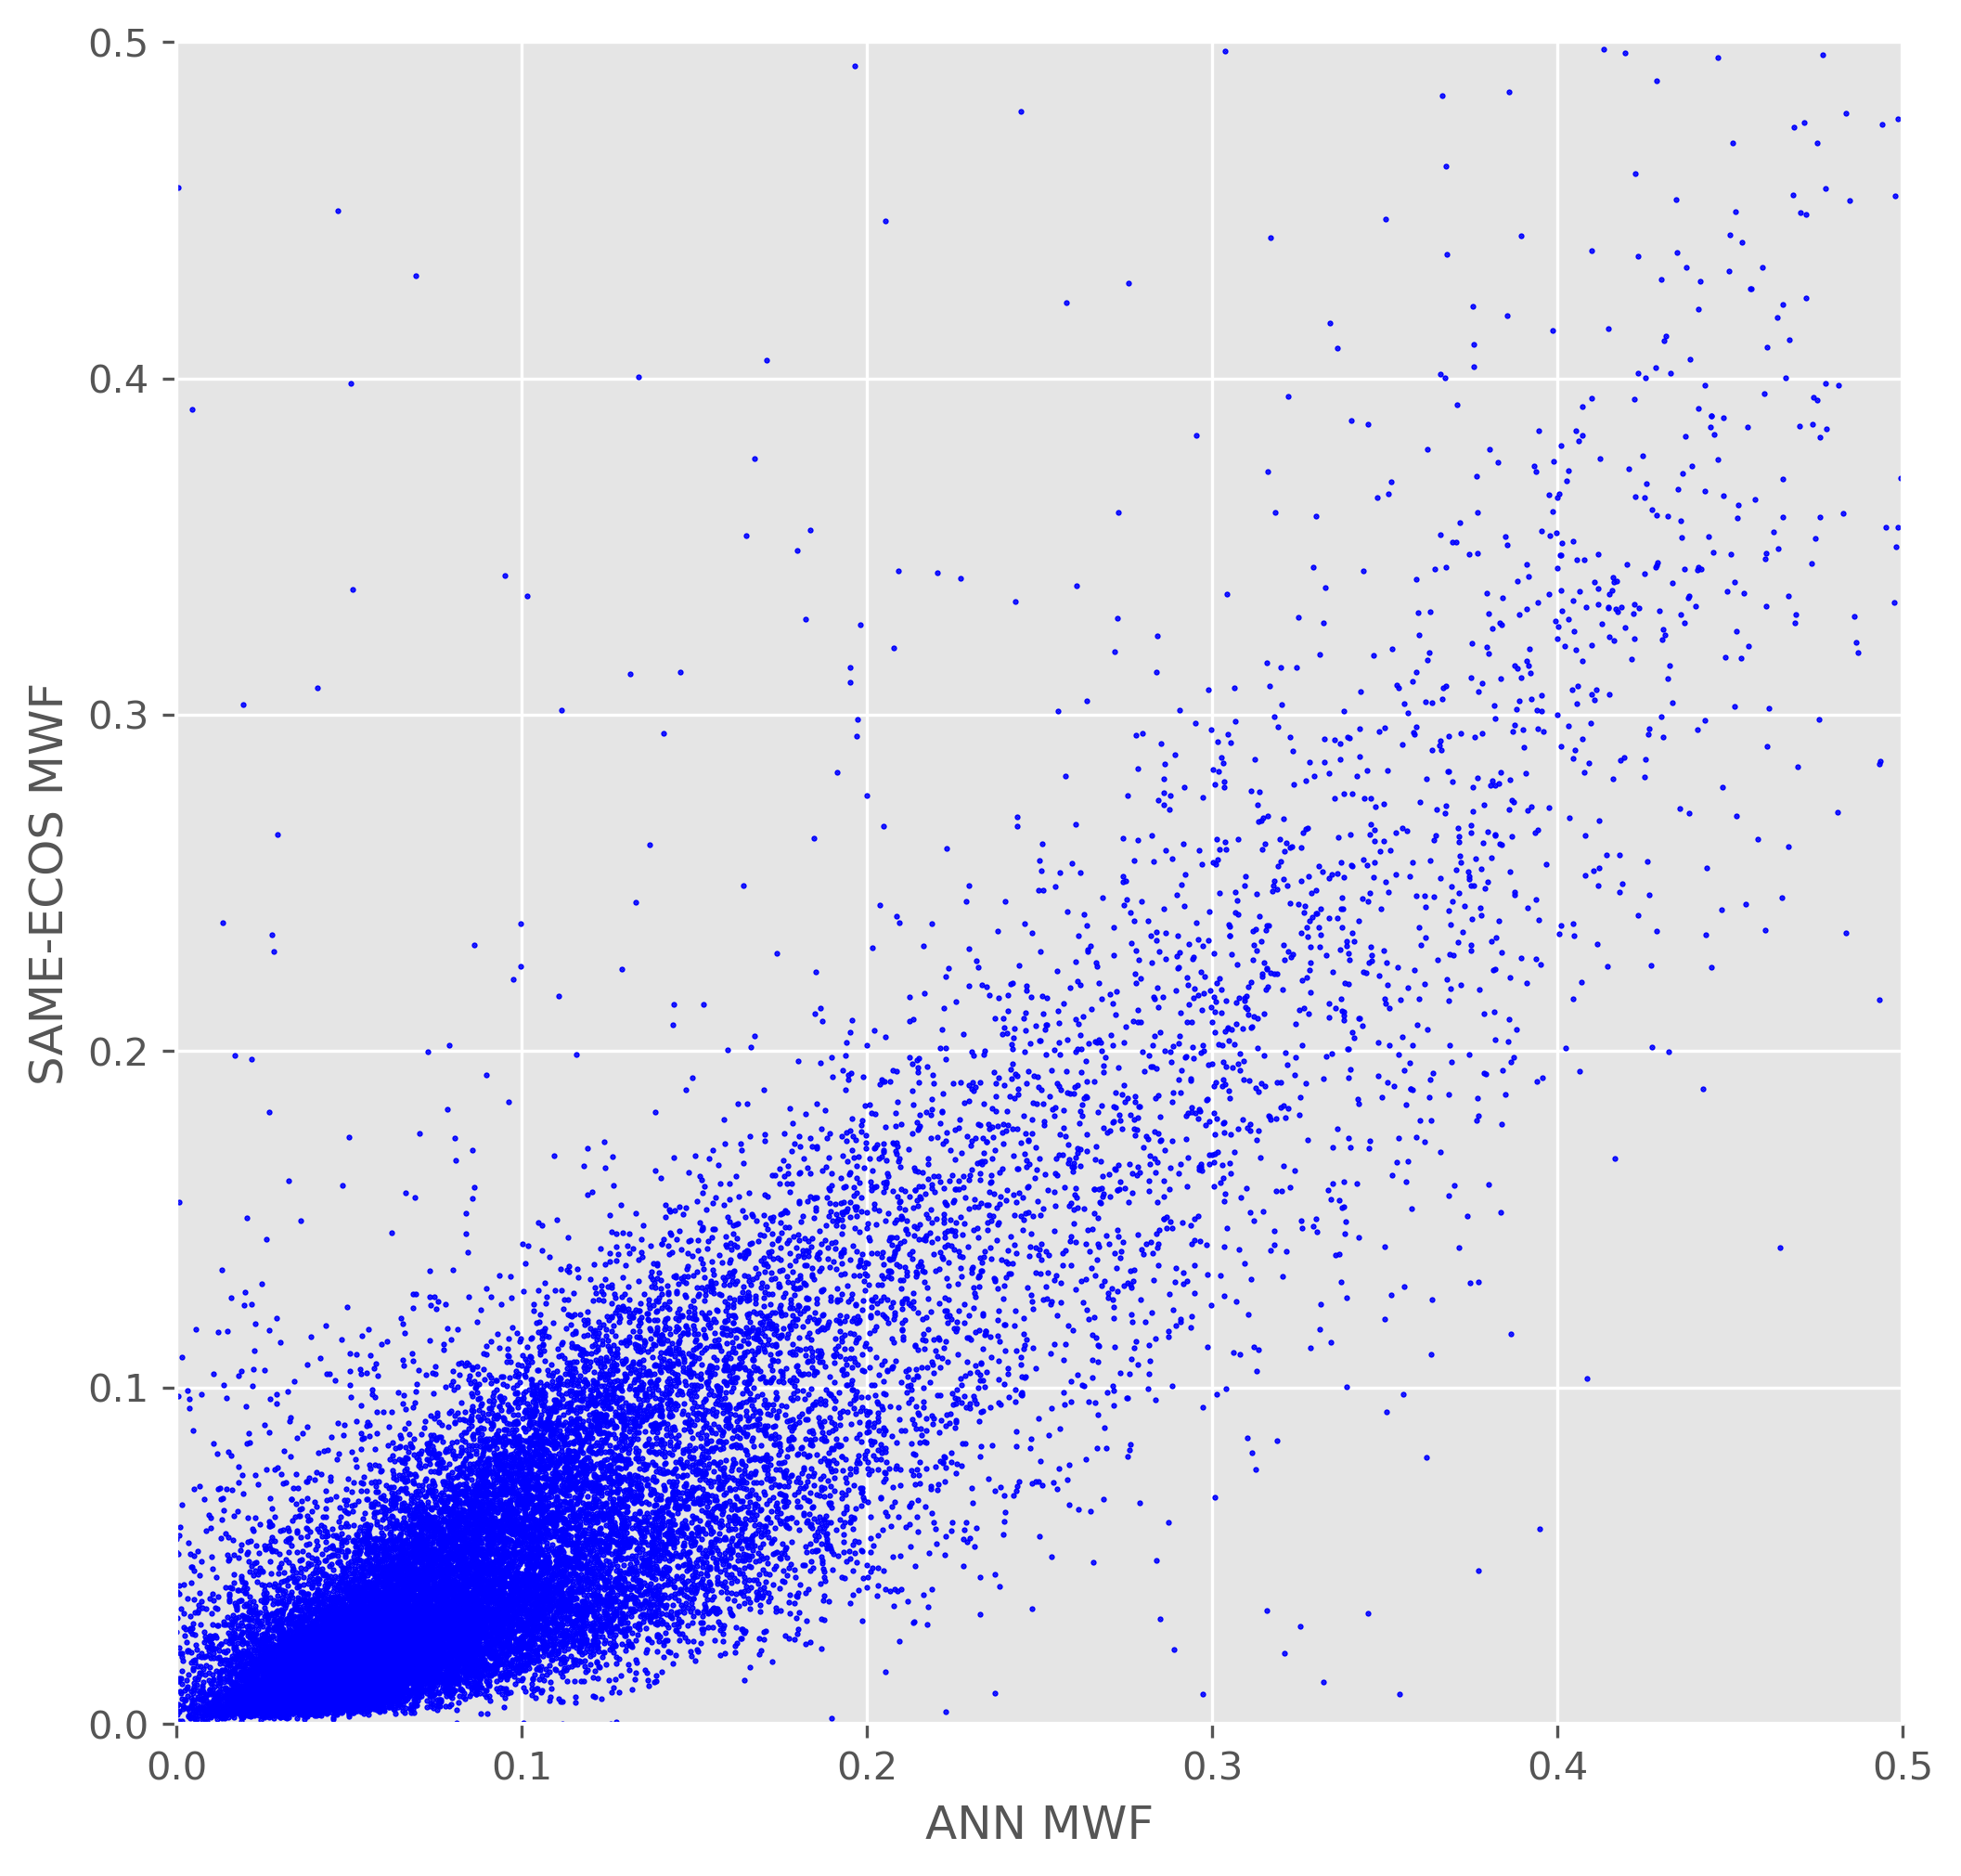

In [208]:
plt.figure(figsize=(8, 8), dpi=300)

for i in range(120):
    for j in range(106):
        for k in range(62,78,2):
            if NN_predict[i,j,k] !=0 and NN_predict_metrics[i,j,k]!=0:
                plt.plot(NN_predict[i,j,k], NN_predict_metrics[i,j,k], '.', color='blue', markersize=1)

plt.xlabel('ANN MWF')
plt.ylabel('SAME-ECOS MWF')

plt.xlim(0,0.5)            
plt.ylim(0,0.5)            
plt.show()
            
            

In [74]:
CC_mask = nib.load('CC_mask.nii.gz')
CC_mask_data = CC_mask.get_fdata()
CC_mask_data.shape

(135, 106, 120)

In [75]:
CC_mask_data = np.swapaxes(CC_mask_data,0,2)
CC_mask_data.shape

(120, 106, 135)

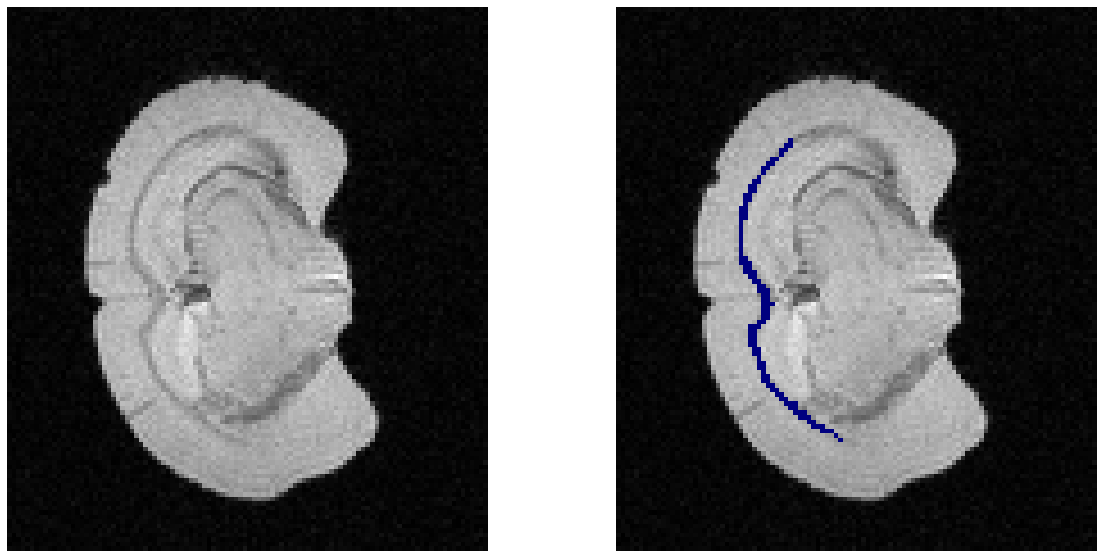

In [79]:
fig=plt.figure(figsize=(20, 10))


fig.add_subplot(1,2,1)
plt.imshow(img_data[:,:,72,10],'gray') ## Show the 11th echo for a good contrast
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(img_data[:,:,72,10],'gray')
plt.imshow(np.ma.masked_where(CC_mask_data == 0, CC_mask_data)[:,:,72],'jet',alpha=1)
plt.axis('off')
plt.show()

In [83]:
CC_mask_4D = np.repeat(CC_mask_data[:, :, :, np.newaxis], 20, axis=3)
CC_mask_4D.shape

(120, 106, 135, 20)

In [84]:
WT_mGRE_CC_data = NN_predict_spectrum*CC_mask_4D
WT_mGRE_CC_data_flat = WT_mGRE_CC_data.reshape(135*106*120,20)
WT_mGRE_CC_data_flat_extracted = WT_mGRE_CC_data_flat[~np.all(WT_mGRE_CC_data_flat == 0, axis=1)]
WT_mGRE_CC_data_flat_extracted.shape

(127, 20)

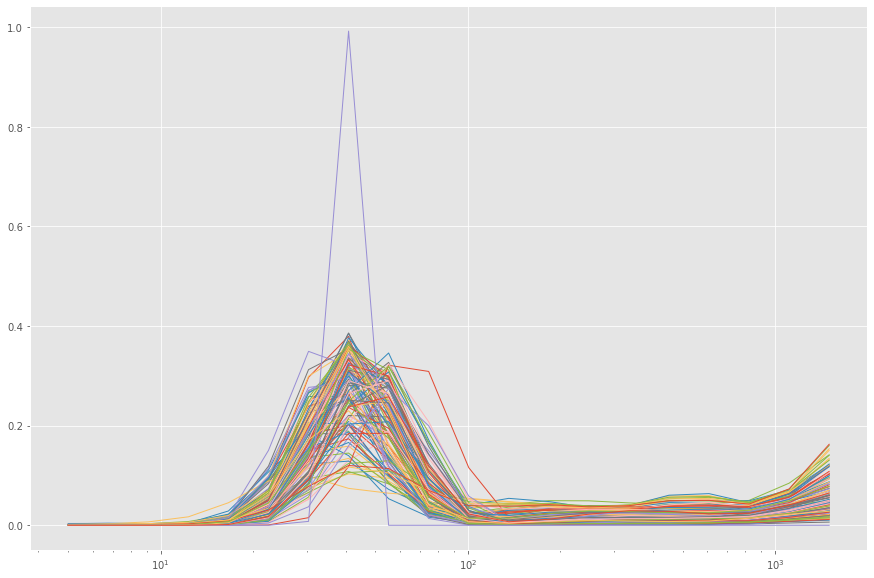

In [93]:
plt.figure(figsize=(15,10))

for i in range(WT_mGRE_CC_data_flat_extracted.shape[0]):
    plt.plot(t2_basis, WT_mGRE_CC_data_flat_extracted[i,:],linewidth=1)
plt.xscale('log')
plt.show()
    

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


NameError: name 'NNLS' is not defined

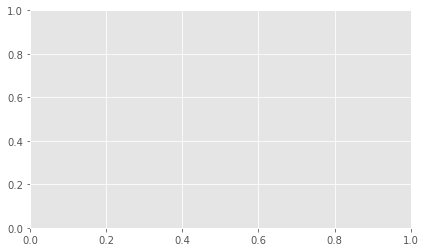

In [88]:
%time
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
WT_mGRE_CC_spectrum_flat_extracted_NNLS = np.zeros([WT_mGRE_CC_data_flat_extracted.shape[0], 20])
for i in range(WT_mGRE_CC_data_flat_extracted.shape[0]-1):    
    WT_mGRE_CC_spectrum_flat_extracted_NNLS[i,:] = NNLS(kernel_matrix, WT_mGRE_CC_data_flat_extracted[i,:])[0]    
    plt.plot(t2_star_basis, WT_mGRE_CC_spectrum_flat_extracted_NNLS[i,:], linewidth=0.3, color='gray')
WT_mGRE_CC_data_flat_extracted[-1,:] = NNLS(kernel_matrix, WT_mGRE_CC_data_flat_extracted_odd_echo[-1,:])[0]
plt.plot(t2_star_basis, WT_mGRE_CC_spectrum_flat_extracted_NNLS[-1,:], label='Voxel spectrum', linewidth=0.3, color='gray')
plt.plot(t2_star_basis, WT_mGRE_CC_spectrum_flat_extracted_NNLS.mean(axis=0), label='Mean spectrum', linewidth=2, color='r')
plt.xscale('log')
plt.xlabel('$T_2^*$ (ms)')
plt.ylabel('Amplitude (a.u.)')
plt.title('NNLS $T_2^*$ spectra (no regularization)')
plt.legend()

fit_WT_mGRE_CC_data_flat_extracted_odd_echo = kernel_matrix.dot(WT_mGRE_CC_spectrum_flat_extracted_NNLS.T)
diff = WT_mGRE_CC_data_flat_extracted_odd_echo - fit_WT_mGRE_CC_data_flat_extracted_odd_echo.T
FNR = WT_mGRE_CC_data_flat_extracted_odd_echo[:,0]/np.abs(diff).mean(axis=1)
plt.text(200, 4.1, 'Fit to Noise Ratio: \nFNR = {:.2f} $\pm$ {:.2f}'.format(FNR.mean(),FNR.std()))

plt.subplot(1,2,2)
WT_mGRE_CC_spectrum_flat_extracted = np.zeros([WT_mGRE_CC_data_flat_extracted_odd_echo.shape[0], num_t2_star_basis])
reg = ElasticNet(alpha=0.005, l1_ratio=0.5, positive=True)
for i in range(WT_mGRE_CC_data_flat_extracted_odd_echo.shape[0]-1):    
    reg.fit(kernel_matrix, WT_mGRE_CC_data_flat_extracted_odd_echo[i,:])
    WT_mGRE_CC_spectrum_flat_extracted[i,:] = reg.coef_
    plt.plot(t2_star_basis, WT_mGRE_CC_spectrum_flat_extracted[i,:], linewidth=0.3, color='gray')
reg.fit(kernel_matrix, WT_mGRE_CC_data_flat_extracted_odd_echo[-1,:])
WT_mGRE_CC_spectrum_flat_extracted[-1,:] = reg.coef_
plt.plot(t2_star_basis, WT_mGRE_CC_spectrum_flat_extracted[-1,:], label='Voxel spectrum', linewidth=0.3, color='gray')
plt.plot(t2_star_basis, WT_mGRE_CC_spectrum_flat_extracted.mean(axis=0), label='Mean spectrum in CC', linewidth=2, color='r')
plt.xscale('log')
plt.xlabel('$T_2^*$ (ms)')
plt.ylabel('Amplitude (a.u.)')
plt.title('NNLS $T_2^*$ spectra (both $L1$ and $L2$ regularization)')
plt.legend()

fit_WT_mGRE_CC_data_flat_extracted_odd_echo = kernel_matrix.dot(WT_mGRE_CC_spectrum_flat_extracted.T)
diff = WT_mGRE_CC_data_flat_extracted_odd_echo - fit_WT_mGRE_CC_data_flat_extracted_odd_echo.T
FNR = WT_mGRE_CC_data_flat_extracted_odd_echo[:,0]/np.abs(diff).mean(axis=1)
plt.text(200, 0.5, 'Fit to Noise Ratio: \nFNR = {:.2f} $\pm$ {:.2f}'.format(FNR.mean(),FNR.std()))

plt.show()